In [20]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [21]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [22]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
len(df_train)/len(df), len(df_val)/len(df), len(df), len(df_val)

(0.9642465458145908, 0.035753454185409164, 844338, 30188)

In [23]:
final_train = False

In [24]:
def get_metric(sales, sales_):
    return np.sqrt((((sales - sales_)/sales)**2).sum()/len(sales))


$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}$


In [25]:
df_train.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week',
       'Day', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
       'CompetitionOpenSince', 'Promo2Since', 'State', 'file', 'week', 'trend',
       'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE', 'trend_DE',
       'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitatio

In [26]:
df_train['Events']

30188     20
30189     20
30190      0
30191     20
30192     20
          ..
844333    10
844334    10
844335    10
844336     1
844337    10
Name: Events, Length: 814150, dtype: int64

In [27]:
max_sales = df_train['Sales'].max()
df.loc[:, 'Sales_norm'] = df['Sales'].values/max_sales

In [28]:
df_train.loc[:, 'Sales_norm'] = df_train['Sales'].values/max_sales
df_val.loc[:, 'Sales_norm'] = df_val['Sales'].values/max_sales

C:\Users\ibajl\AppData\Local\Temp\ipykernel_10888\2193462401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'Sales_norm'] = df_train['Sales'].values/max_sales
C:\Users\ibajl\AppData\Local\Temp\ipykernel_10888\2193462401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'Sales_norm'] = df_val['Sales'].values/max_sales


In [29]:
print('Train:')
print(get_metric(df_train['Sales_norm'], 
                 df_train['Sales_norm'].mean()))
print('Val:')
get_metric(df_val['Sales_norm'], 
           df_train['Sales_norm'].mean())

Train:
0.6371089378658743
Val:


0.5496723521813329

In [33]:
preds = df_train.groupby('Store').Sales.mean()

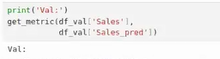


In [35]:
df_val = df_val.merge(preds, on = 'Store', how = 'left', suffixes = ("", '_pred'))

In [36]:
print('Val:')
get_metric(df_val['Sales'],df_val['Sales_pred'])

Val:


0.3071746085338871

In [44]:
def get_mean_by_column_ivo(column, sales_str):
    preds = df_train.groupby(column).Sales_norm.mean()
    df_train_pred = df_train.merge(preds, on = column, how='left', suffixes=("", '_pred'))
    df_val_pred = df_val.merge(preds, on = column, how='left', suffixes=("", '_pred'))
    print('Train: ', get_metric(df_train_pred[sales_str], 
                                df_train_pred[sales_str + '_pred']))
    print('Val: ', get_metric(df_val_pred[sales_str], 
                                df_val_pred[sales_str + '_pred']))

In [39]:
def get_mean_by_column(column, sales_str):
    group_means_dict = {}
    group_mean_list = []
    for col_value, group_df in df_train.groupby(column):
        group_mean =  group_df[group_df[sales_str] > 0][sales_str].mean()
        group_means_dict[col_value] = group_mean
        group_mean_list.append(group_mean)
    print('Train:', get_metric(df_train[sales_str], 
                               df_train[column].apply(group_means_dict.get)))
    print('Val:', get_metric(df_val[sales_str], 
                             df_val[column].apply(group_means_dict.get)))
    return group_means_dict, group_mean_list

In [45]:
# Media por store
# _ = get_mean_by_column('Store', 'Sales_norm')
get_mean_by_column_ivo('Store', 'Sales_norm')

Train:  0.3960913521241833
Val:  0.3071746085338872


In [13]:
# Media por dia de la semana
_ = get_mean_by_column('DayOfWeek', 'Sales_norm')

Train: 0.6008874922754364
Val: 0.5061392186635405


In [46]:
# Media por numera de semana (1-52)
_ = get_mean_by_column('Week', 'Sales_norm')
get_mean_by_column_ivo('Week', 'Sales_norm')

Train: 0.6077405789213655
Val: 0.5171468581189804
Train:  0.6077405789213655
Val:  0.5171468581189804


In [15]:
_ = get_mean_by_column('Month', 'Sales_norm')

Train: 0.6326710739722268
Val: 0.544465040070309


In [16]:
_ = get_mean_by_column('StateHoliday', 'Sales_norm')

Train: 0.6379671046048598
Val: 0.5494193814701794


In [17]:
_ = get_mean_by_column('SchoolHoliday', 'Sales_norm')

Train: 0.6352131730794401
Val: 0.5522886254888293


In [47]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [48]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [62]:
def get_keras_LR(X_columns, hidden_units=1):
    inputs = []
    activation = 'linear'
    if hidden_units>1:
        activation = 'relu'
    for i, col in enumerate(X_columns):
        inp = Input(shape=(X_train[i].shape[1],), name=f"{col}_input")
        inputs.append(inp)
    if len(X_columns)>1:
        concat_out = Concatenate()(inputs)
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(concat_out)
    else:
        dense_out = Dense(hidden_units, name='Dense', activation=activation)(inputs[0])
    if hidden_units>1:
        dense_out = Dense(1, name='Dense_out')(dense_out)
    model = Model(inputs, dense_out)
    model.compile(optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model


def get_embedings_NN(X_columns, hidden_units = 20, activation = 'relu'):
    embed_outs = []
    inputs = []
    for i, col in enumerate(X_columns):
        inp = Input(shape=(1,), name=f"{col}_input")
        inputs.append(inp)
        if col in embed_outs_dict:
            embed_out = Embedding(len(np.unique(X_train[i])), embed_outs_dict[col], name=f"{col}_embedding", mask_zero=False)(inp)
            out = Flatten(name=f"{col}_flatten")(embed_out)
            embed_outs.append(out)
        else:
            embed_outs.append(inp)
        
    if len(X_columns)>1:
        concat_out = Concatenate()(embed_outs)
        
        #Esto lo agrego yo:
        dense_0 = Dense(20,activation='relu')(concat_out)
        dense_1 = Dense(20,activation='relu')(dense_0)
        dense_2 = Dense(20,activation='relu')(dense_1)
        
        dense_out = Dense(hidden_units, activation=activation)(dense_2)
    else:
        dense_out = Dense(hidden_units, activation=activation)(out)
    out = Dense(1)(dense_out)
    model = Model(inputs, out)
    model.compile(optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=[rmspe, 'mse'])
    return model

In [63]:
with_embed = True

embed_outs_dict = {'Store': 2, 'DayOfWeek': 2} #,  'Week': 2, 'Month': 2}
X_columns = list(embed_outs_dict.keys())# + ['BeforeStateHoliday_bool', 'Max_TemperatureC'] # ['Precipitationmm']

if final_train:
    X_train = np.hsplit(df[X_columns].values, len(X_columns))
    y_train = df['Sales_norm']
else:
    X_train = np.hsplit(df_train[X_columns].values, len(X_columns))
    y_train = df_train['Sales_norm']
    
X_val = np.hsplit(df_val[X_columns].values, len(X_columns))
X_test = np.hsplit(df_test[X_columns].values, len(X_columns))

if not with_embed:
    for i in range(len(X_train)):
        X_train[i] = to_categorical(X_train[i])
        X_val[i] = to_categorical(X_val[i])
        X_test[i] = to_categorical(X_test[i])

y_val = df_val['Sales_norm']

In [51]:
if with_embed:
    model = get_embedings_NN(X_columns)
else:
    model = get_keras_LR(X_columns, hidden_units=20)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Store_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Store_embedding     │ (None, 1, 2)      │      2,230 │ Store_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek_embedding │ (None, 1, 2)      │         14 │ DayOfWeek_input[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Store_flatten       │ (None, 2)         │          0 │ Store_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DayOfWeek_flatten   │ (None, 2)         │          0 │ DayOfWeek_embedd… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4)         │          0 │ Store_flatten[0]… │
│ (Concatenate)       │                   │            │ DayOfWeek_flatte… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        100 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 20)        │        420 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │        420 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 20)        │        420 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         21 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,625 (14.16 KB)

 Trainable params: 3,625 (14.16 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# weights = model.get_weights()
# weights[0] = np.array(np.array(stores_mean_list).reshape(-1, 1))
# model.set_weights(weights)

In [52]:
from tensorflow.keras import callbacks

In [53]:
# model.evaluate(X_val, y_val)

In [54]:
# np.sqrt(0.0951)

In [55]:
epochs = 5
model.compile(optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[rmspe, 'mse'])
cbs = [callbacks.ReduceLROnPlateau(monitor='val_rmspe', mode='min', verbose=1, patience=2), callbacks.ModelCheckpoint('best_val_rmspe.hdf5.keras', monitor='val_rmspe', mode='min', verbose=1, save_best_only=True)]
if final_train:
    # Esto lo agrego yo:
    # model.fit(X_train, y_train, epochs=epochs, callbacks=cbs)
    model.fit(X_train, y_train, batch_size=256, epochs=epochs, callbacks=cbs)
else:
    # Esto lo agrego yo:
    # model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=cbs)
    model.fit(X_train, y_train, epochs=epochs, batch_size=256, validation_data=(X_val, y_val), callbacks=cbs)

Epoch 1/5


c:\Users\ibajl\miniconda3\envs\Redes_neuro\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Store_input', 'DayOfWeek_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3172/3181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030 - mse: 0.0030 - rmspe: 0.3595

c:\Users\ibajl\miniconda3\envs\Redes_neuro\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Store_input', 'DayOfWeek_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(



Epoch 1: val_rmspe improved from inf to 0.21248, saving model to best_val_rmspe.hdf5.keras
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0030 - mse: 0.0030 - rmspe: 0.3593 - val_loss: 0.0014 - val_mse: 0.0014 - val_rmspe: 0.2125 - learning_rate: 0.0010
Epoch 2/5
3162/3181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - rmspe: 0.2820
Epoch 2: val_rmspe did not improve from 0.21248
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0018 - mse: 0.0018 - rmspe: 0.2820 - val_loss: 0.0014 - val_mse: 0.0014 - val_rmspe: 0.2194 - learning_rate: 0.0010
Epoch 3/5
3169/3181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - mse: 0.0018 - rmspe: 0.2768
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 3: val_rmspe did not improve from 0.21248
3181/3181 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0018 - mse: 0.0018 - rmspe: 0.2768 - val_loss: 0.0013 - val_mse: 0.0013 - val_rmspe: 0.2136 - learning_rate: 0.0010
Epoch 4/5
3176/3181 ━━━━━━━━━━

In [56]:
model.load_weights('best_val_rmspe.hdf5.keras')

In [57]:
model.evaluate(X_train, y_train)

25443/25443 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0018 - mse: 0.0018 - rmspe: 0.2212


[0.0017128123436123133, 0.23193241655826569, 0.0017128123436123133]

In [58]:
model.evaluate(X_val, y_val)

944/944 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0016 - mse: 0.0016 - rmspe: 0.2115


[0.0013096485054120421, 0.20892482995986938, 0.0013096485054120421]

In [59]:
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [33]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 2)


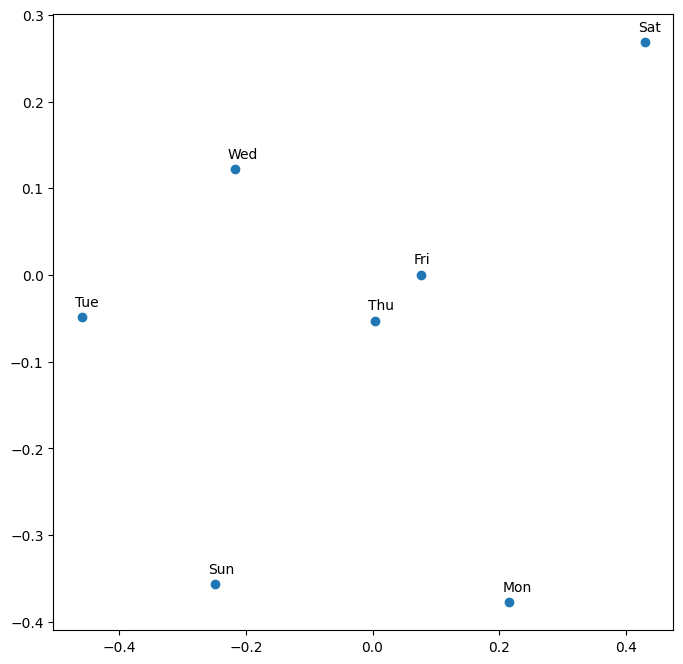

In [34]:
plot_embed('DayOfWeek_embedding', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(1115, 2)


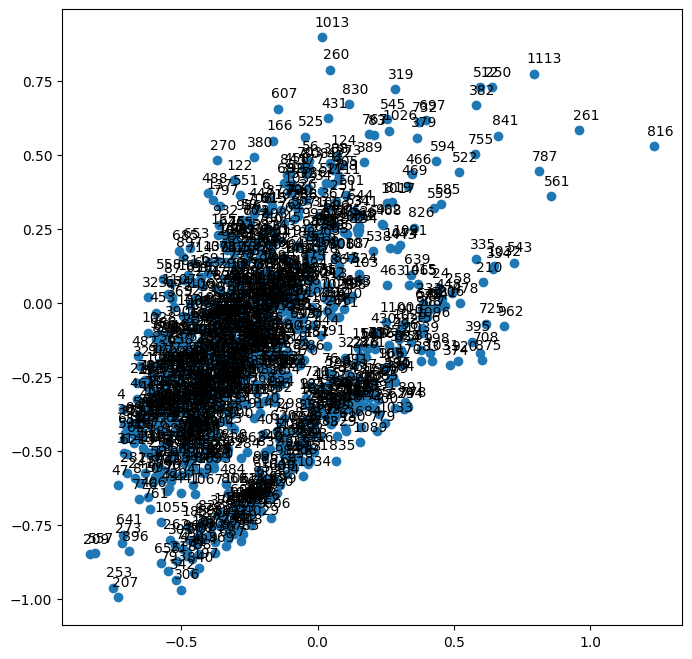

In [35]:
plot_embed('Store_embedding', list(range(1115)))

In [36]:
train_predictions = model.predict(X_train)*max_sales
get_metric(df_train['Sales'].values, train_predictions.reshape(-1))

   14/25443 ━━━━━━━━━━━━━━━━━━━━ 1:43 4ms/step     

c:\Users\lucas\miniconda3\envs\venv_rn_01\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Store_input', 'DayOfWeek_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


25443/25443 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step


0.3191614180530704

In [37]:
test_predictions = model.predict(X_test)*max_sales
test_predictions[df_test['Open'] == 0] = 0

1284/1284 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [61]:
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = test_predictions
sample_csv.head()

sample_csv.to_csv(f'submision_baseline_{"-".join(X_columns)}.csv', index=False)
